 ## Probabilistic Programming from Scratch 3: Performance and PyMC3

https://www.safaribooksonline.com/oriole/probabilistic-programming-from-scratch-3-improving-algorithmic-performance-and-online-learning

- What probabilistic programming truly means?
- Bayesian method's value in probabilistic programming
- ABC quantifies risk, inserts institutional knowledge, and handles on-line learning
- Compare the qualities of a custom-built ABC based system vs. off-the-shelf PyMC3

>> Approximate Bayesian Computation is a brute force algorithm. It works, but it's not quick. We're going to:

### APPROXIMATE BAYESIAN COMPUTATION REFRESHER

In [2]:
import itertools
import random

def abayes(data, prior_sampler, simulate, compare):
    '''Yield samples from the posterior by Approximate Bayesian Computation.'''
    for p in prior_sampler:
        if compare(simulate(p), data):
            yield p


# prior_sampler
def uniform_prior_sampler():
    '''Yield random numbers in interval (0, 1).'''
    while True:
        yield random.random()

# simulate
def simulate_conversion(p, n_visitors):
    '''Return number of vistors who convert given conversion fraction p.'''
    return sum(random.random() < p for _ in range(n_visitors))

# compare
def compare_conversion(sim, obs):
    '''Return True if two observations are the same.'''
    return sim == obs

# take to take a specific number of samples from a generator and load them as a list.
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(itertools.islice(iterable, n))

In [3]:
posterior_sampler = abayes(
    data=4,
    prior_sampler=uniform_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, 100),
    compare=compare_conversion)

%timeit take(1, posterior_sampler)

2.41 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
# What if we have ten times as many conversions and visitors: 40/1000

posterior_sampler_big = abayes(
    data=40,
    prior_sampler=uniform_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, 1000),
    compare=compare_conversion)

%timeit take(1, posterior_sampler_big)

The slowest run took 75.91 times longer than the fastest. This could mean that an intermediate result is being cached.
245 ms ± 206 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


> We need thousands of samples from the posterior to build up a complete picture of the posterior distribution.

#### IMPROVING PERFORMANCE
> We can do this by changing the compare function to give it some "fuzziness", 

In [5]:
def compare_conversion_fuzzy(sim, obs, tol=0.1):
    '''Return True if two observations agree within a relative tolerance.'''
    return abs(sim - obs)/(sim + 1.0) < tol

> This function returns True if the difference between sim and obs is less than 10% of the value of sim. The +1 is in there to make sure we don't divide by zero.

In [6]:
posterior_sampler_big_fuzzy = abayes(
    data=40,
    prior_sampler=uniform_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, 1000),
    compare=compare_conversion_fuzzy)

%timeit take(1, posterior_sampler_big_fuzzy)

print("\n That's a big speedup of a factor of 10 or so \n ")

34.6 ms ± 9.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

 That's a big speedup of a factor of 10 or so 
 


> fuzzy comparison means that you get a fuzzy posterior. 
>> The peak will be in the right place, but it will be smeared out.

In [7]:
nsamples = 100
a_samples = take(nsamples, posterior_sampler_big)
a_samples_fuzzy = take(nsamples, posterior_sampler_big_fuzzy)

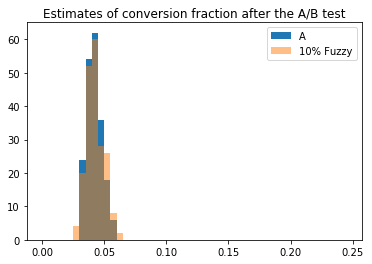

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

abbins = [i/200.0 for i in range(50)]  # 50 bins between 0 and 0.25
plt.hist(a_samples, bins=abbins, label='A', normed=True)
plt.hist(a_samples_fuzzy, bins=abbins, label='10% Fuzzy', alpha=0.5, normed=True)
plt.title('Estimates of conversion fraction after the A/B test')
plt.legend();

***

#### THE GERMAN TANK PROBLEM

- German tanks were assigned a serial number when they rolled off the production line 
- The first tank was number 0, the next was number 1, and so on, up to n_tanks-1
- __The question is__: given those n_caught serial numbers, how many tanks does Germany have, i.e. what is n_tanks?

### To use our function abayes() we need the four arguments:

1. data
2. a generator that yields samples from the prior
3. a function to simulate the data given values of n_tanks and n_caught
4. a function to compare the data with the outcome of a simulation

> Let's assume the Allies catch two tanks and these have these serial numbers.
>> Next, the generator to get samples from the prior. The Allies know the Germans have at least max(captured_tanks) tanks.

In [9]:
captured_tanks = [314, 421]
max_upper=5000

In [10]:
def prior_ntanks_sampler(captured_tanks, upper=max_upper):
    '''Yield random integers in the range (max(captured_tanks), upper).'''
    while True:
        yield random.randint(max(captured_tanks), upper)

>> Now a function to simulate the data, assuming there are N tanks, and the Allies catch m.

>>Note that this function uses sample which ensures that we don't get the same number twice. You can't capture a tank twice.

In [11]:
def simulate_tanks(n_tanks, n_caught):
    '''Return serial numbers of n_caught tanks given there are a total of n_tanks.'''
    return random.sample(range(n_tanks), n_caught)

> Finally, we need a function to compare the serial numbers of the observed tanks and the results of a simulation.

>> Again, to speed things up, we'll give our function a tolerance, so that the simulation needs to be similar to the data, rather than identical.

In [12]:
def compare_tanks(obs1, obs2, tol=20):
    '''Return True if two sets of serial numbers agree within a tolerance.'''
    return all(abs(o1 - o2) <= tol 
               for o1, o2 in zip(sorted(obs1), sorted(obs2)))

>> Now we're all set to run abayes and draw 1000 samples from the posterior distribution for the number of tanks.

In [13]:
posterior_ntanks_sampler = abayes(
    captured_tanks,
    prior_ntanks_sampler(captured_tanks),
    lambda n_tanks: simulate_tanks(n_tanks, len(captured_tanks)),
    compare_tanks)

tank_samples = take(1000, posterior_ntanks_sampler)

>> overplot the analytic solution to this problem. This is the known correct answer 

In [14]:
from math import factorial


def binom(x, y):
    '''Return binomial coefficient for x, y.'''
    return factorial(x)//(factorial(y) * factorial(x - y))


def analytic_solution(n_tanks, captured_tanks):
    '''Probability that there are n_tanks given a list of captured serial numbers.'''
    k = len(captured_tanks)
    if k < 2:
        raise ValueError("Analytic formula valid for len(captured_tanks) >= 2.".format(k))
    m = max(captured_tanks)
    if n_tanks < m:
        return 0.0
    else:
        return (k - 1)/k * binom(m - 1, k - 1)/binom(n_tanks, k)

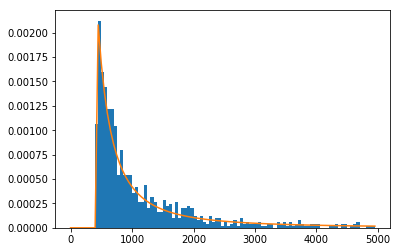

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

tank_bins = range(0, 5000, 50)
plt.hist(tank_samples, normed=True, bins=tank_bins)
plt.plot(tank_bins, [analytic_solution(x, captured_tanks) for x in tank_bins]);

## what's the probability that Germany has more than 1000 tanks.

In [16]:
pro=sum(t > 1000 for t in tank_samples)/len(tank_samples)
print( "The probability that Germany has more than 1000 tanks = ", pro)



The probability that Germany has more than 1000 tanks =  0.367


***

__Probabilistic programming__ is an approach to language or library design that hides the complexity of solving an inference problem.

> all you have to do is write two functions and a generator.
> need to graduate to industrial strength sampling algorithms.
> The best-known examples are:

1. __Markov Chain Monte Carlo__ [Link](https://jeremykun.com/2015/04/06/markov-chain-monte-carlo-without-all-the-bullshit/)     (which includes Metropolis Hastings and Gibbs sampling) 

2. __Hamiltonian Monte Carlo__  [link](https://www.safaribooksonline.com/oriole/(http://blog.fastforwardlabs.com/2017/01/30/the-algorithms-behind-probabilistic-programming.html)

3. __ADVI__

** These are super fast, but fragile and tough to implement.**

> using an off-the-shelf probabilistic programming system called PyMC3. It's not only orders of magnitude faster, it also makes specifying your simulation process much easier because fundamental ideas like random variables and distributions are primitive objects that can be composed together

In [18]:
from pymc3 import DiscreteUniform, Model, sample

with Model():
    n_tanks = DiscreteUniform('n_tanks', lower=max(captured_tanks), upper=5000)
    obs = DiscreteUniform('obs', lower=0, upper=n_tanks, observed=captured_tanks) 
    trace = sample(10000)

Assigned Metropolis to n_tanks
100%|██████████| 10500/10500 [00:01<00:00, 7129.67it/s]


 >>> If you go back in this notebook and add more tanks to captured_tanks, the speed difference becomes even starker

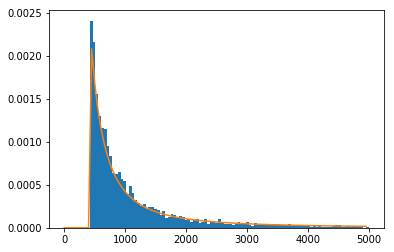

In [19]:
burn_in = 1000
plt.hist(trace[burn_in:].get_values('n_tanks'), normed=True, bins=100)
plt.plot(tank_bins, [analytic_solution(x, captured_tanks) for x in tank_bins]);


> We used a uniform prior for the German tank problem. Change the function prior_ntanks_sampler to be a plausible non-uniform prior. See how that affects not only the answer but the running time of the sampler.



> The PyMC3 solution to the German tank problem has a tiny bug. It samples with replacement, which means it can simulate the capture of two tanks that have the same serial number. Google around and figure out how to fix this.

> Copy abayes into a new notebook on your machine and see if you can solve this problem: I have five coins. They are all equally unfair, i.e. they all have the same probability p of coming up heads. I toss each coin ten times and get [5, 3, 2, 4, 3] heads. Use abayes to figure out the posterior probability distribution of p. What's the probability that p is greater than 0.5, i.e. the coin has a bias toward heads?

### Doing Bayesian Data Analysis R 

https://www.safaribooksonline.com/library/view/doing-bayesian-data/9780123814852/

>> Complete Notbook List

https://github.com/JWarmenhoven/DBDA-python

### markov-chain-monte-carlo-without-all-the-bullshit 

https://jeremykun.com/2015/04/06/markov-chain-monte-carlo-without-all-the-bullshit/